<a href="https://colab.research.google.com/github/CIT-NLP/NLP-final-project/blob/main/XGBoostwithSMOTE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!gdown https://drive.google.com/uc?id=1fcBqqNnfu_EDbYW5IkiF8FYX5WSQDg3j
!gdown https://drive.google.com/uc?id=1qzdOfeIyjPkDl-RtpVhkaY08h3yizEdn

Downloading...
From: https://drive.google.com/uc?id=1fcBqqNnfu_EDbYW5IkiF8FYX5WSQDg3j
To: /content/random_genre.csv
100% 235M/235M [00:02<00:00, 89.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1qzdOfeIyjPkDl-RtpVhkaY08h3yizEdn
To: /content/subset_genre.csv
100% 99.1M/99.1M [00:02<00:00, 38.4MB/s]


In [2]:
import pandas as pd
from ast import literal_eval

df_random = pd.read_csv("./random_genre.csv")
df_subset = pd.read_csv('./subset_genre.csv')

# interpret cols as lists instead of strings
for col in ['unigrams', 'sentences', 'lem_sent', 'lem_sent_join']: 
  df_random[col] = df_random[col].apply(literal_eval)
  df_subset[col] = df_subset[col].apply(literal_eval)


In [17]:
# imports
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import gensim
from gensim.models.doc2vec import TaggedDocument
import multiprocessing as mp
from gensim.models import Doc2Vec
from sklearn import utils
import numpy as np
from imblearn.over_sampling import SMOTE
import xgboost 
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Random Dataframe

In [28]:
train, test = train_test_split(df_random, test_size=0.2, random_state=42)
train_tagged = train.apply(lambda r: TaggedDocument(words=r['unigrams'], tags=r.genre), axis=1)
test_tagged = test.apply(lambda r: TaggedDocument(words=r['unigrams'], tags=r.genre), axis=1)

In [29]:
#train doc2vec model 
model_dbow = Doc2Vec(dm = 0, workers = mp.cpu_count())
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

for epoch in range(5):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 13939/13939 [00:00<00:00, 2877185.21it/s]


In [30]:
def create_embedding(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags, model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [31]:
y_train, X_train = create_embedding(model_dbow, train_tagged)
y_test, X_test = create_embedding(model_dbow, test_tagged)

X_train = np.asarray(X_train)
X_test = np.asarray(X_test)
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

## Without SMOTE

In [32]:
xgb = XGBClassifier().fit(X_train, y_train)
y_pred = xgb.predict(X_test)

print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing accuracy 0.4444763271162123
Testing F1 score: 0.3928584972322372


Text(0.5, 1.0, 'Confusion Matrix')

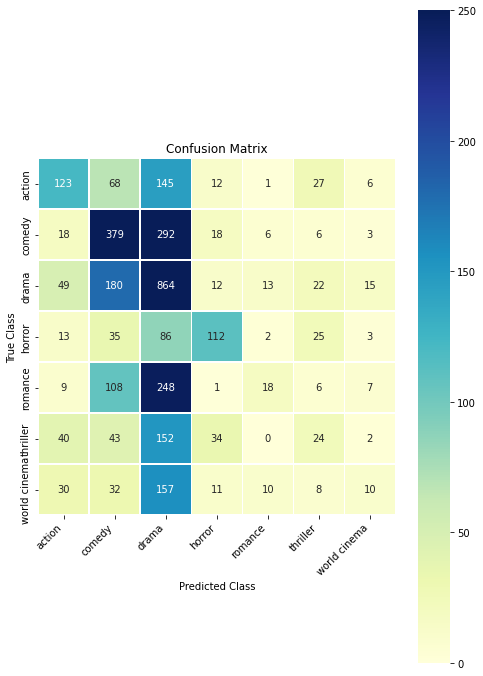

In [27]:
conf = confusion_matrix(y_test, y_pred)
classes = xgb.classes_

f, ax = plt.subplots(figsize=((8,12)))

hmap = sns.heatmap(conf, annot=True, linewidth=.5,fmt='d',ax=ax, square=True, cmap='YlGnBu', vmax=250)
hmap.set_xticklabels(hmap.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_xticklabels(classes)
ax.set_yticklabels(classes)

ax.set_xlabel("Predicted Class")
ax.set_ylabel("True Class")
ax.set_title("Confusion Matrix")

## With SMOTE

In [12]:
os = SMOTE(random_state = 0)
os_smote_X,os_smote_Y = os.fit_resample(X_train, y_train)

xgb = XGBClassifier().fit(os_smote_X, os_smote_Y)
y_pred = xgb.predict(X_test)

print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing accuracy 0.3793400286944046
Testing F1 score: 0.38259425938945385


# Subset Dataframe

In [13]:
train, test = train_test_split(df_subset, test_size=0.2, random_state=42)
train_tagged = train.apply(lambda r: TaggedDocument(words=r['unigrams'], tags=r.genre), axis=1)
test_tagged = test.apply(lambda r: TaggedDocument(words=r['unigrams'], tags=r.genre), axis=1)

In [14]:
#train doc2vec model and create embeddings
model_dbow = Doc2Vec(dm = 0, workers = mp.cpu_count())
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

for epoch in range(5):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

y_train, X_train = create_embedding(model_dbow, train_tagged)
y_test, X_test = create_embedding(model_dbow, test_tagged)

X_train = np.asarray(X_train)
X_test = np.asarray(X_test)
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

100%|██████████| 5582/5582 [00:00<00:00, 3014757.27it/s]


## Without SMOTE

In [15]:
xgb = XGBClassifier().fit(X_train, y_train)
y_pred = xgb.predict(X_test)

print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing accuracy 0.6060171919770774
Testing F1 score: 0.5937116326355694


## With SMOTE

In [16]:
os = SMOTE(random_state = 0)
os_smote_X,os_smote_Y = os.fit_resample(X_train, y_train)

xgb = XGBClassifier().fit(os_smote_X, os_smote_Y)
y_pred = xgb.predict(X_test)

print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing accuracy 0.5988538681948424
Testing F1 score: 0.6007052323694091


Text(0.5, 1.0, 'Confusion Matrix')

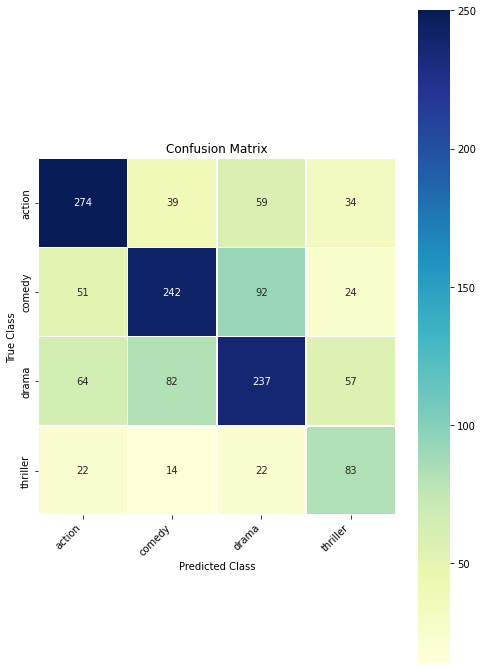

In [21]:
# plotting 
conf = confusion_matrix(y_test, y_pred)
classes = xgb.classes_

f, ax = plt.subplots(figsize=((8,12)))

hmap = sns.heatmap(conf, annot=True, linewidth=.5,fmt='d',ax=ax, square=True, cmap='YlGnBu', vmax=250)
hmap.set_xticklabels(hmap.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_xticklabels(classes)
ax.set_yticklabels(classes)

ax.set_xlabel("Predicted Class")
ax.set_ylabel("True Class")
ax.set_title("Confusion Matrix")